In [152]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
%matplotlib inline

In [153]:
import sys

sys.path.insert(0, '/home/shenwanxiang/Research/aliyun_sync/COMPASS/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, score2

In [199]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=16,) 

def bootstrap_score(df, n_bootstrap=100, random_state=42):
    rng = np.random.default_rng(random_state)
    results = []
    for i in range(n_bootstrap):
        sample_idx = rng.choice(df.index, size=len(df), replace=True)
        sample = df.loc[sample_idx]

        score = score2(
            sample['R'],
            sample['1'],
            sample[['0','1']].idxmax(axis=1).astype(int)
        )
        results.append(score)
    return pd.DataFrame(results)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [234]:
data_path = '/home/shenwanxiang/Research/aliyun_sync/COMPASS/paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE.ALIGN'))

dfp = pd.read_csv('../04_model_performance/02_leave_one_cohort_out/bootstrap_results/LOCO_raw_data.csv', 
                  index_col = 0)

dfp = dfp[dfp['mode'] == 'PFT']
dfp = dfp[dfp['seed'] == 42]
dfp = dfp.set_index('Index')

df_label = df_label.join(dfp[['NR','R', '0', '1']])

#BLCA_primary_tissues = ['Bladder', 'Kidney', 'Ureter']
primary_tissues = ['Skin', 'Mucosa', 'Ocular']
metastatic_tissues = ['Lymph node', 'Lung', 'Liver', 'Brain', 'Soft tissue', 'Other']


data = df_label[df_label.cancer_type == 'SKCM']
data = data[~data.Biopsy_site.isna()]

n1 = data.Biopsy_site.isin(primary_tissues).sum()
n2 = data.Biopsy_site.isin(metastatic_tissues).sum()


x1 = f'Primary site\n(n={n1})'
x2 = f'Metastatic site\n(n={n2})'

tissue_type_map1 = {'Skin':x1, 'Mucosa':x1, 'Ocular':x1, 
                    'Lymph node':x2, 'Lung':x2, 'Liver':x2, 
                    'Brain':x2, 'Soft tissue':x2, 'Other':x2}

Primary site
(n=253) vs. Metastatic site
(n=77): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.274e-02 Stat=1.904e+03


(<Axes: ylabel='AUROC'>,
 [<statannotations.Annotation.Annotation at 0x7fe44a0854c0>])

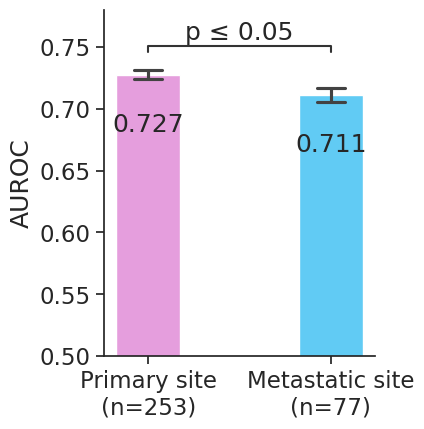

In [254]:
# data = df_label[df_label.cohort == 'IMVigor210']

data['tissue_type'] = data.Biopsy_site.map(tissue_type_map1)
data = data[~data.tissue_type.isna()]

print(data.tissue_type.value_counts())
dfr = data.groupby('tissue_type').parallel_apply(bootstrap_score)
dfr.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfr = dfr.reset_index()
dfr = dfr.rename(columns = {'level_1':'bootstrap'})

from statannotations.Annotator import Annotator
x = 'tissue_type'
y = 'ROC'
order = [x1, x2]
pairs = [(x1, x2)]

palette = [ '#E59EDD', '#61CBF4']
width = 0.35

fig, ax = plt.subplots(figsize=(3.5, 4.5), )
barplot = sns.barplot(data  = dfr, x = x, order = order,saturation = 1, capsize=0.15,
             width = width, palette=palette,errorbar = 'se', 
            #legend=False,
            y = y, ax=ax)

for bar in barplot.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height-0.05,  # Slightly above the bar
        f'{height:.3f}',  # Format to 3 decimal places
        ha='center', va='bottom', #fontsize=9
    )


ax.set_ylim(0.5, 0.75)
ax.set_ylabel('AUROC')
ax.set_xlabel('')
sns.despine()

ax.tick_params(bottom=True, left=True)
annot = Annotator(
    ax, pairs,
    data=dfr, x = x, y = y, 
    order = order,  width = width, 
    # DO NOT pass plot='barplot'
)
annot.configure(
    test='Wilcoxon',                 # or 'Mann-Whitney'
    comparisons_correction='fdr_bh',
    text_format='simple',
    show_test_name=False,
    #line_offset=0.02,  # Controls vertical spacing from the bar
    #line_height=0.01            # Controls height of the annotation line

)
annot.apply_and_annotate()

# fig.savefig(f'./results/LGR_ROC_barplot.svg',
#             bbox_inches = 'tight')

In [267]:
#BLCA_primary_tissues = ['Bladder', 'Kidney', 'Ureter']
primary_tissues = ['Skin', 'Mucosa', 'Ocular']
metastatic_tissues = ['Lymph node', 'Lung', 'Liver', 'Brain', 'Soft tissue', 'Other']


data = df_label[df_label.cancer_type == 'SKCM']
data = data[~data.Biopsy_site.isna()]

n1 = data.Biopsy_site.isin(['Skin']).sum()
n2 = data.Biopsy_site.isin(['Lymph node']).sum()
n3 = data.Biopsy_site.isin(['Lung', 'Liver', 'Brain']).sum()

x1 = f'Primary:\nSkin\n(n={n1})'
x2 = f'Metastatic\nLymph node\n(n={n2})'
x3 = f'Metastatic\nLung/Liver/Brain\n(n={n3})'

tissue_type_map2 = {'Skin':x1,
                    'Lymph node':x2, 
                    'Lung':x3, 
                    'Liver':x3, 
                    'Brain':x3, }

Primary:\nSkin\n(n=229)                 229
Metastatic\nLymph node\n(n=28)           28
Metastatic\nLung/Liver/Brain\n(n=27)     27
Name: tissue_type, dtype: int64


Primary:
Skin
(n=229) vs. Metastatic
Lymph node
(n=28): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.186e-12 Stat=4.580e+02
Metastatic
Lymph node
(n=28) vs. Metastatic
Lung/Liver/Brain
(n=27): Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:4.397e-18 Stat=4.000e+00


(<Axes: ylabel='AUROC'>,
  <statannotations.Annotation.Annotation at 0x7fe4220d1280>])

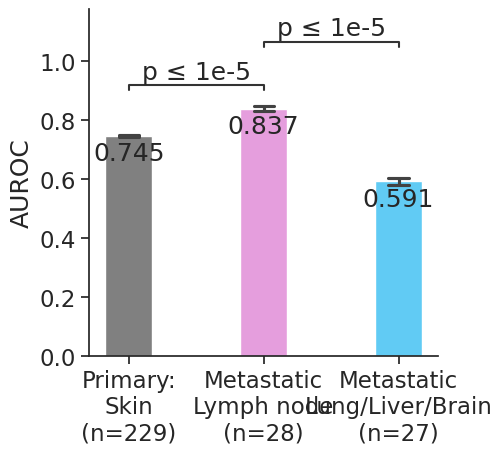

In [269]:
data['tissue_type'] = data.Biopsy_site.map(tissue_type_map2)
data = data[~data.tissue_type.isna()]
print(data.tissue_type.value_counts())
dfr = data.groupby('tissue_type').parallel_apply(bootstrap_score)
dfr.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfr = dfr.reset_index()
dfr = dfr.rename(columns = {'level_1':'bootstrap'})

from statannotations.Annotator import Annotator
x = 'tissue_type'
y = 'ROC'
order = [x1, x2, x3]
pairs = [(x2, x1),(x2,x3)]

palette = ['grey','#E59EDD', '#61CBF4']
width = 0.35

fig, ax = plt.subplots(figsize=(3*1.5, 4.5), )
barplot = sns.barplot(data  = dfr, x = x, order = order,saturation = 1, capsize=0.15,
             width = width, palette=palette,errorbar = 'se', 
            #legend=False,
            y = y, ax=ax)

for bar in barplot.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height-0.1,  # Slightly above the bar
        f'{height:.3f}',  # Format to 3 decimal places
        ha='center', va='bottom', #fontsize=9
    )


#ax.set_ylim(0.5, 0.75)
ax.set_ylabel('AUROC')
ax.set_xlabel('')
sns.despine()

ax.tick_params(bottom=True, left=True)


annot = Annotator(
    ax, pairs,
    data=dfr, x = x, y = y, 
    order = order,  width = width, 
    # DO NOT pass plot='barplot'
)
annot.configure(
    test='Wilcoxon',                 # or 'Mann-Whitney'
    comparisons_correction='fdr_bh',
    text_format='simple',
    show_test_name=False,
    #line_offset=0.02,  # Controls vertical spacing from the bar
    #line_height=0.01            # Controls height of the annotation line

)
annot.apply_and_annotate()

# fig.savefig(f'./results/LGR_ROC_barplot.svg',
#             bbox_inches = 'tight')